In [0]:
import imageio
import cv2
import numpy as np
import os
import pickle
import re
import PIL
from PIL import Image

## Challenge Categories

In [0]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]

IMG_W = 60
IMG_H = 80
CHANNELS = 1
SEQ_LEN = 30
INPUT_SHAPE = (SEQ_LEN, IMG_W, IMG_H, CHANNELS)
NCLASSES = 6

EPOCHS = 25
BATCH_SIZE = 64

### Spliting Dataset

In [0]:
# Dataset are divided according to the instruction at:
# http://www.nada.kth.se/cvap/actions/00sequences.txt
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

## Loading Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/train.p", "rb"))
dev_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/test.p", "rb"))

Loading dataset ..


##Preparing dataset

In [0]:
def generate_sequences(ds="train"):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  for video in videos:
    frames = video["frames"]
    sequences = len(frames) // SEQ_LEN
    seq_frames = []
    sequnces_frames = [] 
    step = SEQ_LEN
    for i in range(0, len(frames)):
      if(i < step):
        seq_frames.append(frames[i])
      else:
        sequnces_frames.append(seq_frames)
        seq_frames = []
        step = step + SEQ_LEN + 1
    sequnces_frames = np.array(sequnces_frames[:sequences])
    for seq in sequnces_frames:
      X.append(seq.reshape(INPUT_SHAPE))
      y.append(CATEGORIES.index(video["category"]))

  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)

  return X, y

In [0]:
X_train, y_train = generate_sequences(ds="train")
X_dev, y_dev = generate_sequences(ds="dev")
X_test, y_test = generate_sequences(ds="test")

In [8]:
X_train.shape

(2316, 30, 60, 80, 1)

In [9]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import InputLayer, Input, ZeroPadding3D, Conv3D, MaxPooling3D, Activation, add
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [0]:
# CNN model (VGG-like)
model = Sequential()
weights_init = 'glorot_uniform'

## Stage 1
model.add(ZeroPadding3D((3,3,1), input_shape=INPUT_SHAPE))
model.add(Conv3D(32,(3,3,1),kernel_initializer=weights_init))
model.add(BatchNormalization())
model.add(Conv3D(32,(3,3,1),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,1),padding='valid'))

## Stage 2
model.add(Conv3D(64,(3,3,1),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv3D(64,(3,3,1),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,1),padding='valid'))

## Stage 3
model.add(Conv3D(128,(3,3,1),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv3D(128,(3,3,1),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,1),padding='valid'))

## Output
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(NCLASSES,activation='softmax'))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding3d_2 (ZeroPaddin (None, 36, 66, 82, 1)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 34, 64, 82, 32)    320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 34, 64, 82, 32)    128       
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 32, 62, 82, 32)    9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 62, 82, 32)    128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 16, 31, 82, 32)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 14, 29, 82, 64)   

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
trained_model = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_dev, y_dev) , shuffle=True)

Train on 2316 samples, validate on 2256 samples
Epoch 1/25
2316/2316 [==============================] - 55s 24ms/step - loss: 1.7222 - acc: 0.3903 - val_loss: 2.0917 - val_acc: 0.3435
Epoch 2/25
2316/2316 [==============================] - 52s 22ms/step - loss: 1.1495 - acc: 0.5851 - val_loss: 2.2790 - val_acc: 0.3994
Epoch 3/25
2316/2316 [==============================] - 52s 22ms/step - loss: 0.8207 - acc: 0.6896 - val_loss: 1.4540 - val_acc: 0.4929
Epoch 4/25
2316/2316 [==============================] - 52s 22ms/step - loss: 0.5411 - acc: 0.7915 - val_loss: 0.7823 - val_acc: 0.6804
Epoch 5/25
2316/2316 [==============================] - 52s 22ms/step - loss: 0.4594 - acc: 0.8273 - val_loss: 0.7972 - val_acc: 0.6720
Epoch 6/25
2316/2316 [==============================] - 52s 22ms/step - loss: 0.3910 - acc: 0.8506 - val_loss: 0.7172 - val_acc: 0.7558
Epoch 7/25
2316/2316 [==============================] - 52s 22ms/step - loss: 0.3821 - acc: 0.8454 - val_loss: 0.7426 - val_acc: 0.7265


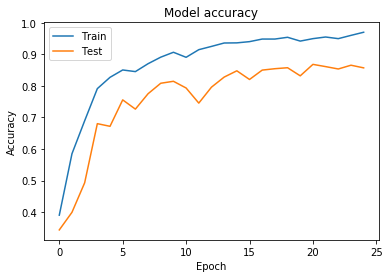

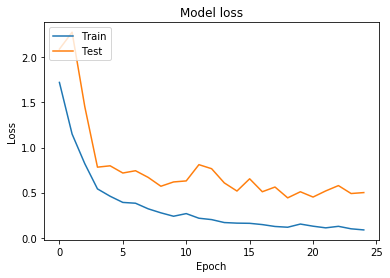

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
model.evaluate(X_test, y_test)

2450/2450 [==============================] - 14s 6ms/step


[0.853433823459461, 0.7824489795918367]

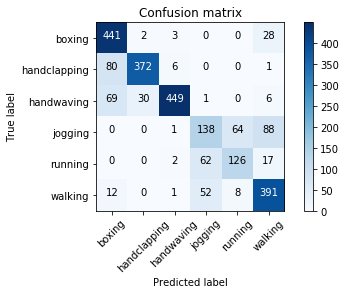

In [22]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [0]:
model.save_weights('3DCNN_KTH.h5')

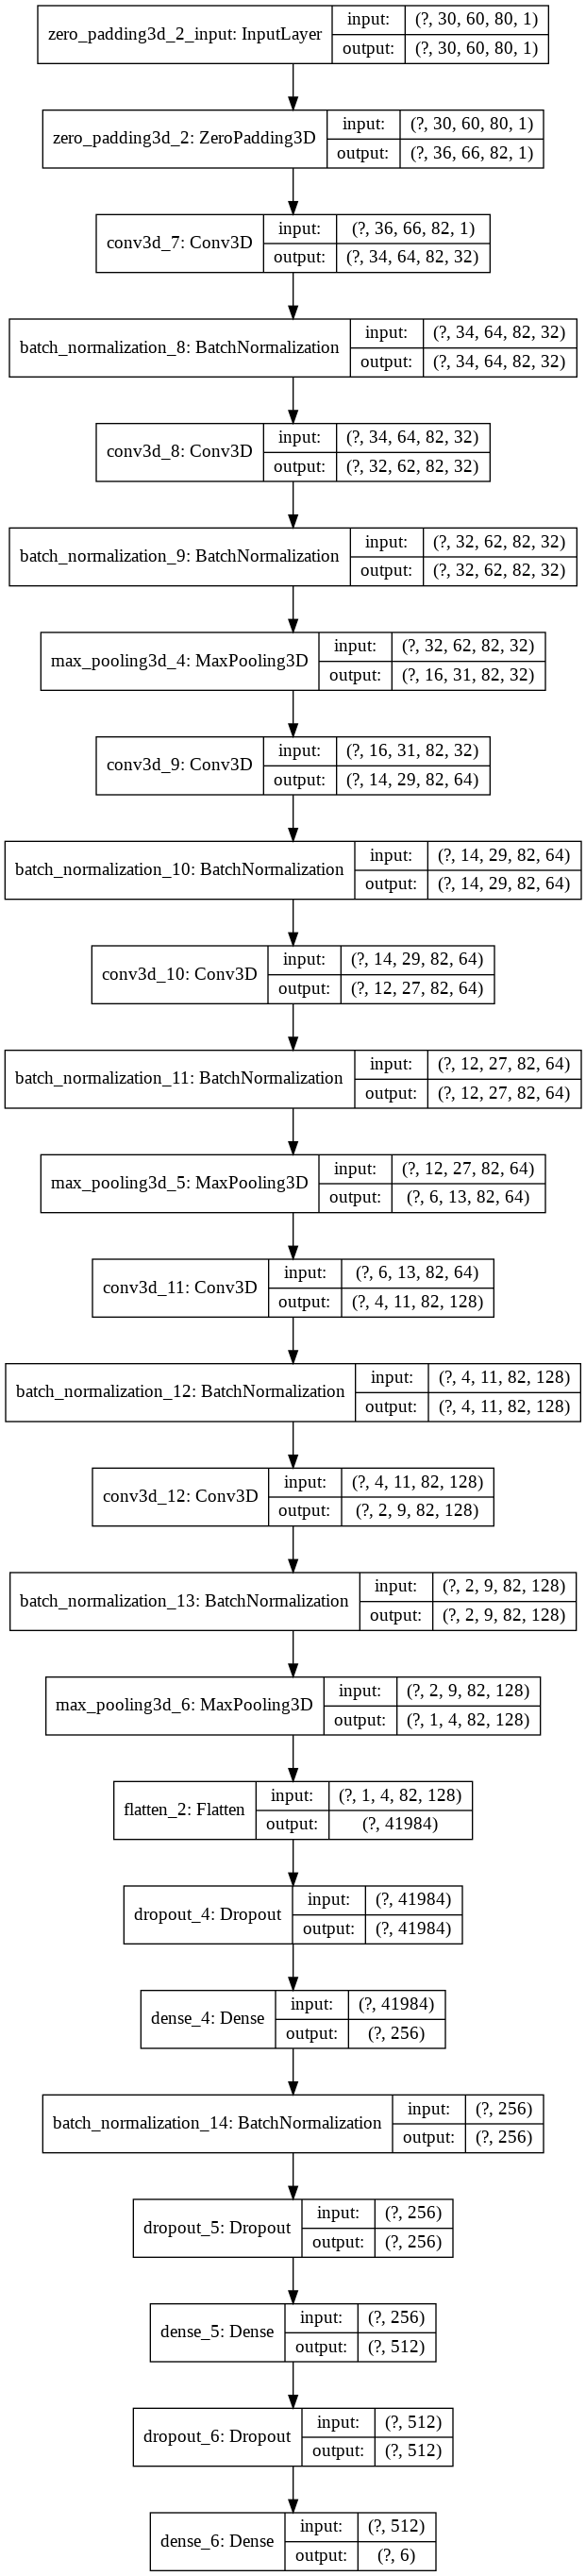

In [26]:
plot_model(model, show_shapes=True, to_file='3DCNN_KTH.png')